In [4]:
from os import listdir
import os.path as op
from glob import glob
import SpectralEvents.spectralevents_functions as tse
import dill

import numpy as np
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pandas as pd

import mne
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap
from mne.report import Report

from alpha_analysis import fit_ssd, ssd_alpha, ssd_spec_ratios

import seaborn as sns
sns.set()


bads = dict(
    DXFTLCJA=[[], ['MRT35-1609', 'MRT15-1609', 'MRP57-1609', 'MRP56-1609',
                   'MRP23-1609', 'MRP22-1609', 'MRO24-1609', 'MLF67-1609',
                   'MLF66-1609', 'MRP34-1609', 'MLT14-1609']],
    BQBBKEBX=[[], ['MRT21-1609', 'MLT31-1609', 'MLT41-1609', 'MLT51-1609',
                   'MLT21-1609', 'MLT16-1609', 'MLT11-1609', 'MLT22-1609',
                   'MLT12-1609', 'MLT32-1609', 'MLT33-1609', 'MLT42-1609',
                   'MLT43-1609', 'MRF14-1609', 'MRT34-1609', 'MRT27-1609']],
    JBGAZIEO=[[], ['MLF25-1609']],
    QGFMDSZY=[['MLP41-1609'], []],
    ZDIAXRUW=[[], []]
)

In [5]:
data_dir = '/home/ntolley/Jones_Lab/biomag_ketamine'
subj_ids = sorted(list({fname[:8] for fname in listdir(data_dir)}))

In [2]:
def analysis(subj_id):
    # read in both sessions belonging to a single subject
    raw_sessions = list()
    session_fnames = sorted(glob(op.join(data_dir, subj_id + '*')))

    fig_alpha_topo, axes = plt.subplots(1, 3, figsize=(9, 3))
    colors = ['grey', 'orange']

    for session_idx, fname in enumerate(session_fnames):
        raw = mne.io.read_raw_ctf(fname, verbose=False)
        raw.load_data()
        # mark bad channels; maintain symmetry of channels across sessions
        if subj_id in bads:
            for bad_sess_idx in range(2):
                for bad_ch in bads[subj_id][bad_sess_idx]:
                    if bad_ch not in raw.info['bads']:
                        raw.info['bads'].append(bad_ch)
        raw.pick_types(meg=True, eeg=False, ref_meg=False)
        raw.filter(l_freq=1., h_freq=50)
        # raw._data = zscore(raw._data, axis=1)
        raw._data -= raw._data.mean()
        raw._data /= raw._data.std()
        raw.resample(sfreq=500)

        # compute raw PSD
        raw_psds, freqs = psd_array_multitaper(raw.get_data(),
                                               raw.info['sfreq'],
                                               fmin=1., fmax=50.)
        # plot channel-mean psd
        chan_avg_psd = raw_psds.mean(axis=0)
        axes[0].plot(freqs, chan_avg_psd, color=colors[session_idx],
                     alpha=0.8)
        axes[0].set_ylabel('power')
        axes[0].set_xlabel('freq. (Hz)')
        # plot alpha topography
        alpha_mask = np.logical_and(freqs >= 9, freqs <= 14)
        avg_alpha_pow = raw_psds[:, alpha_mask].mean(axis=1)
        im, _ = plot_topomap(avg_alpha_pow, raw.info, vmax=70,
                             axes=axes[session_idx + 1],
                             show=False)
        plt.colorbar(im, ax=axes[session_idx + 1])

        raw_sessions.append(raw)

    # concatenate data and compute a single SSD filter that is applied to both
    # sessions
    raw_data = np.stack([raw.get_data() for raw in raw_sessions], axis=0)
    filtered_data, ssd = fit_ssd(raw_data, raw_sessions[0].info)

    # # store filtered data in new Raw instances
    # raw_sessions_filtered = [raw.copy() for raw in raw_sessions]
    # for session_idx, raw_filtered in enumerate(raw_sessions_filtered):
    #     raw_filtered._data = filtered_data[session_idx].copy()

    # fig_spec_ratios = ssd_spec_ratios(raw_sessions_filtered, ssd)
    # fig_ssd, sessions_alpha = ssd_alpha(raw_sessions_filtered, ssd)

    return filtered_data, ssd



    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff freque

<ipython-input-2-45141b3acabf>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_alpha_topo, axes = plt.subplots(1, 3, figsize=(9, 3))


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff freque

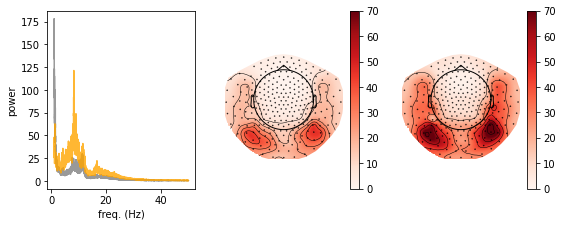

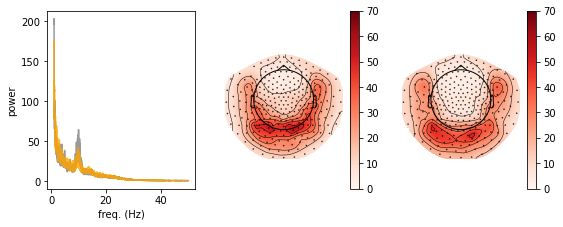

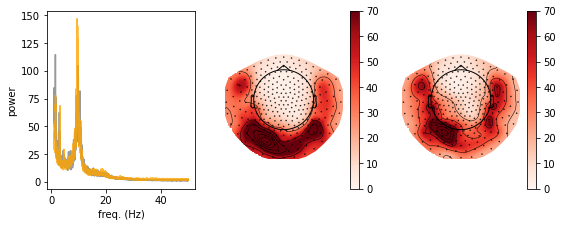

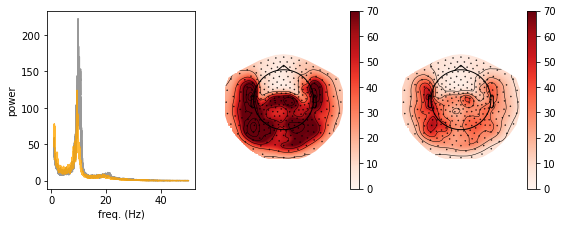

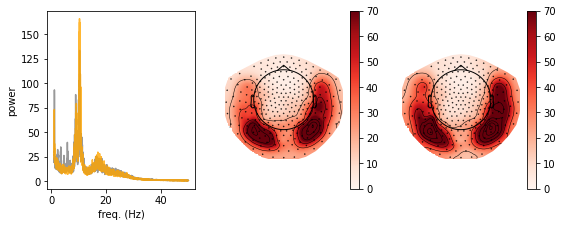

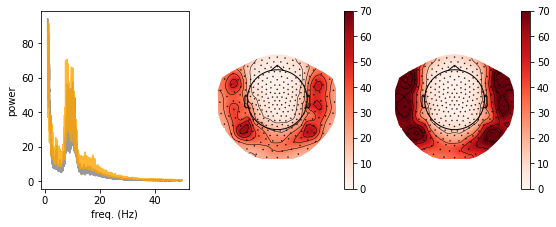

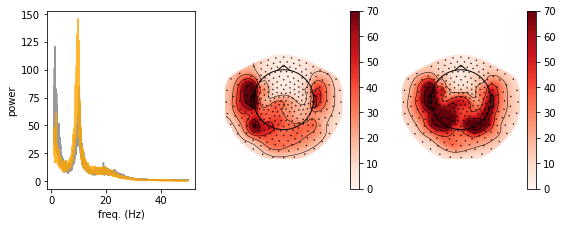

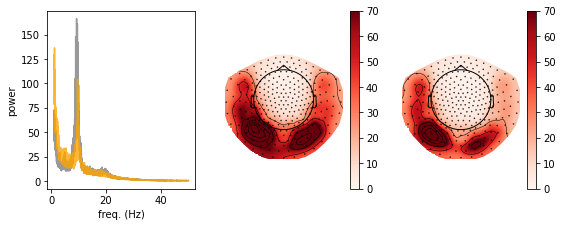

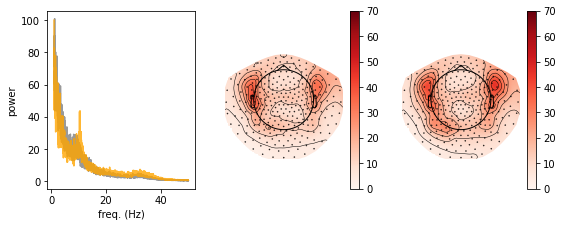

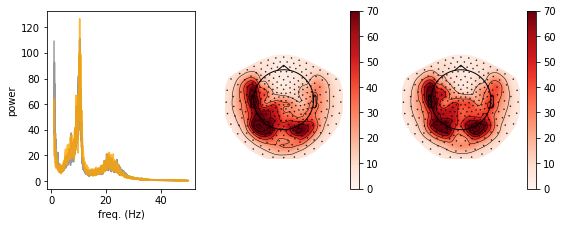

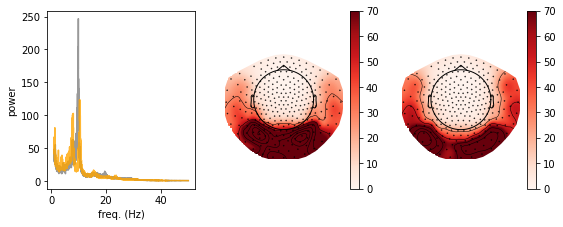

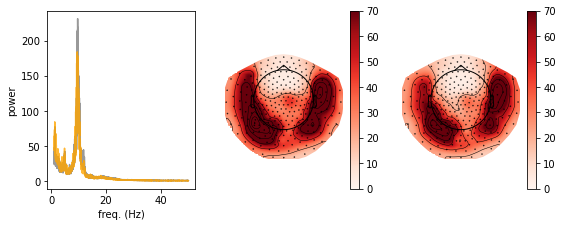

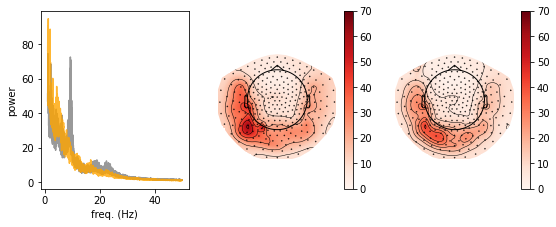

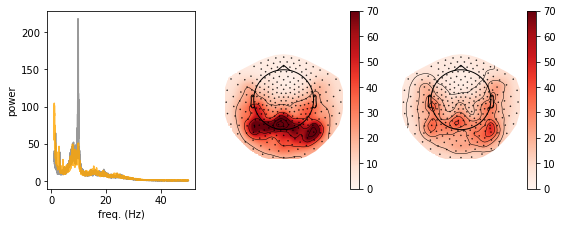

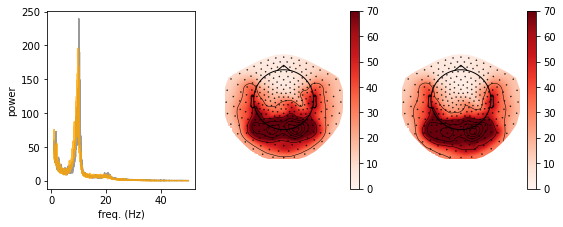

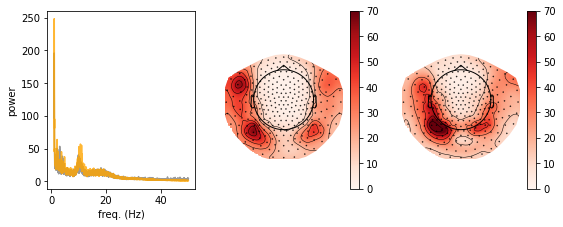

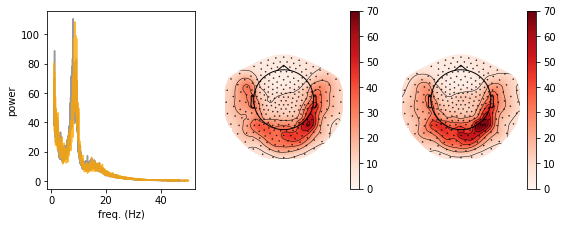

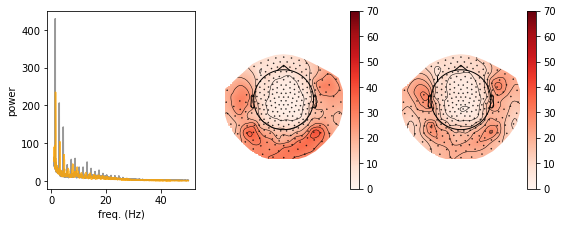

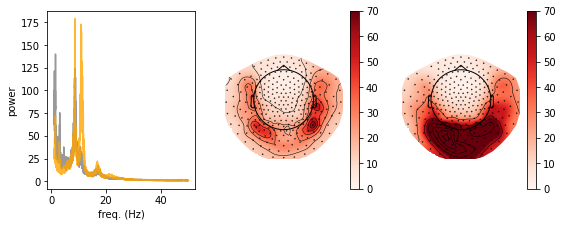

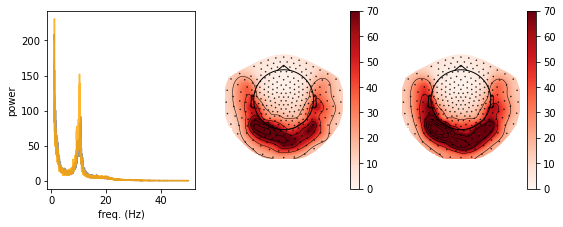

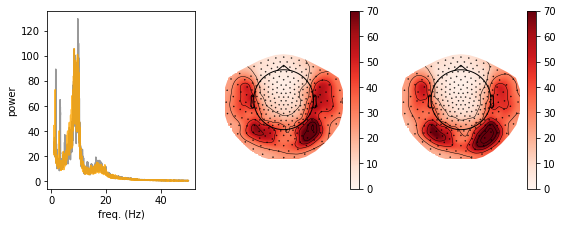

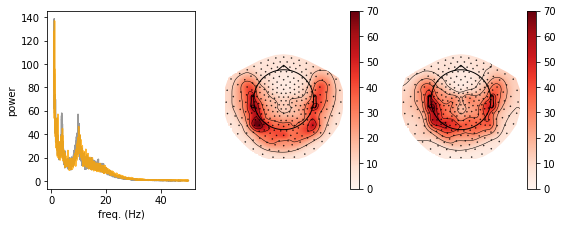

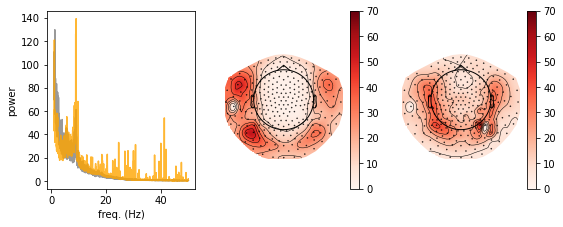

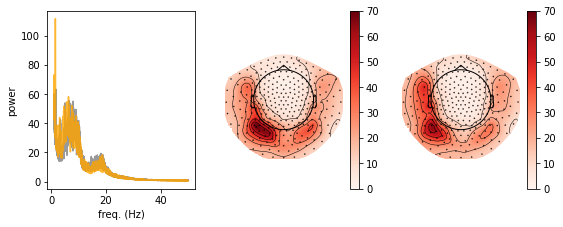

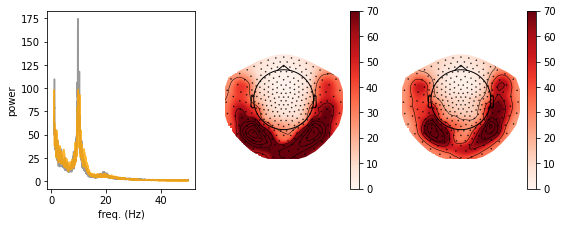

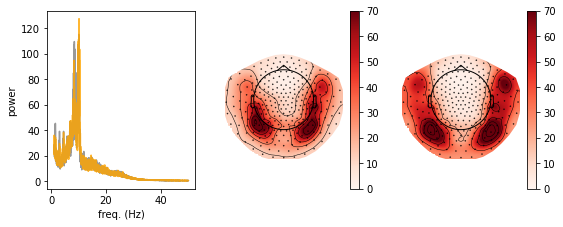

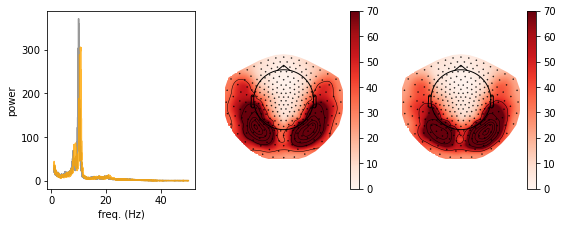

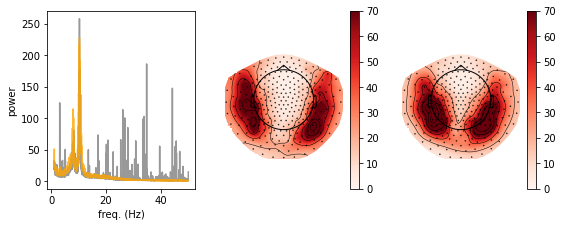

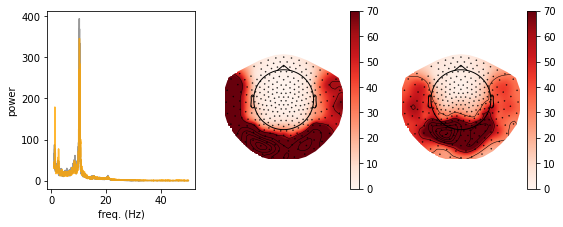

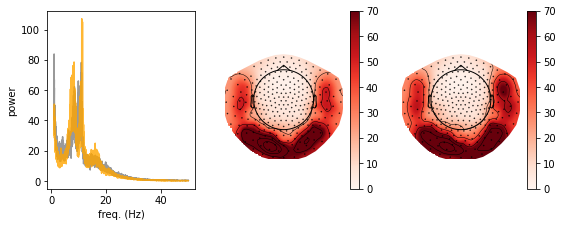

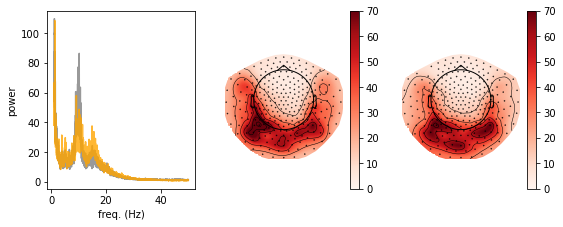

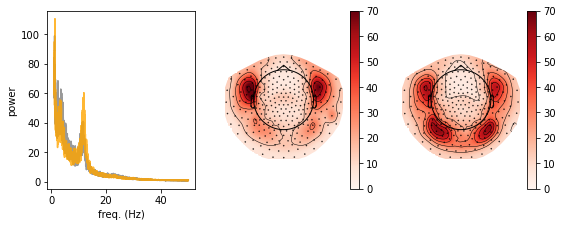

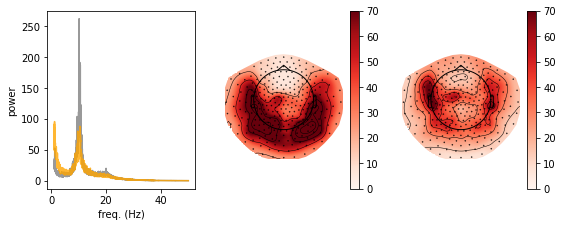

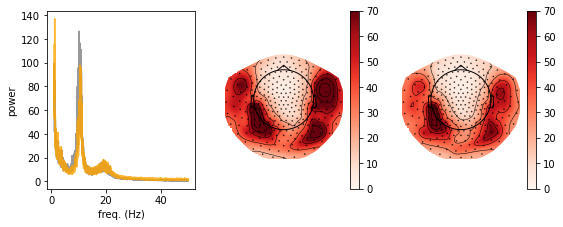

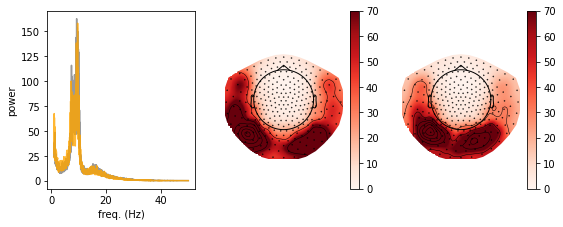

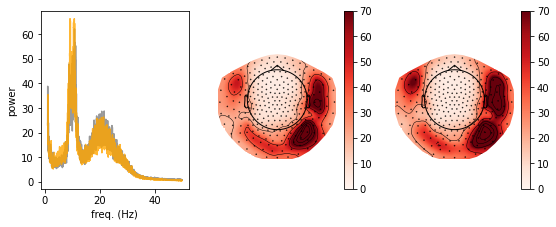

In [3]:
#filtered_data_dict = dict()
for subj_id in subj_ids:
    filtered_data, ssd = analysis(subj_id)
    np.save(f'data/{subj_id}_ssd_filtered.npy', filtered_data[:,:1,:])


In [43]:

#eventBand = [15,29]
eventBand = [9,14]       # Frequency range of spectral events
fVec = np.arange(1,50+1)            # Vector of fequency values over which to calculate TFR
Fs = 500                            # Sampling rate of time-series
findMethod = 1                      # Event-finding method (1 allows for maximal overlap while 2 limits overlap in each respective suprathreshold region)
width = 7

thrFOM = 6; #Factors of Median threshold (see Shin et al. eLife 2017 for details concerning this value)

footprintFreq = 8
footprintTime = 8
threshold = 0.00
neighbourhood_size = (footprintFreq,footprintTime)

df_list = list()
for idx, subj_id in enumerate(subj_ids):
    filtered_data = np.load(f'data/{subj_id}_ssd_filtered.npy')
    numTrials, numSamples = filtered_data[:,0,:].shape

    # Validate fVec input
    Fn = Fs/2                   # Nyquist frequency
    dt = 1/Fs                   # Sampling time interval
    Fmin = 1/(numSamples*dt)    # Minimum resolvable frequency
    tVec = np.linspace(0, numSamples/Fs, numSamples)

    thisTFR = mne.time_frequency.tfr_array_morlet(filtered_data, Fs, fVec)
    thisTFR = np.real(thisTFR).squeeze()

    thisSpecEvents = tse.spectralevents_find(findMethod, thrFOM, tVec, fVec, thisTFR, ['a', 'b'], 
        neighbourhood_size, threshold, Fs)

    drop_cols = ['Event Onset Time', 'Event Offset Time', 'Event Duration', 'Trial', 'Outlier Event']
    df_mean = pd.DataFrame(thisSpecEvents).groupby('Trial').mean().reset_index()
    df_var = pd.DataFrame(thisSpecEvents).groupby('Trial').var().reset_index()
    event_counts = pd.DataFrame(thisSpecEvents)['Trial'].value_counts()
    for col_name in drop_cols:
        _ = df_mean.pop(col_name)
        _ = df_var.pop(col_name)

    df_mean.columns = df_mean.columns + ' Mean'
    df_mean['Trial'] = [0, 1]
    df_var.columns = df_var.columns + ' Var'
    df_var['Trial'] = [0, 1]

    df_temp = pd.merge(df_mean, df_var)
    df_temp.pop('Trial')
    df_temp['Subj'] = [idx,idx]
    df_temp['Counts'] = [event_counts[0], event_counts[1]]

    df_list.append(df_temp)


df = pd.concat(df_list)


In [2]:
#df.to_pickle('data/spectral_event_df.pkl')
df = pd.read_pickle('data/spectral_event_df.pkl')

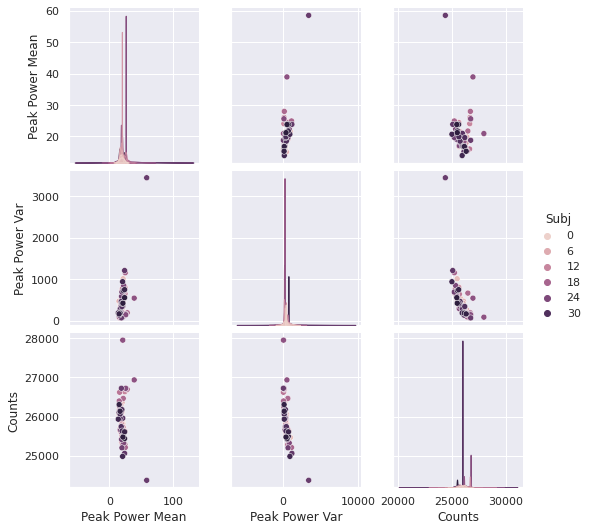

In [4]:
sns.pairplot(df, hue='Subj', vars=['Peak Power Mean', 'Peak Power Var', 'Counts'])

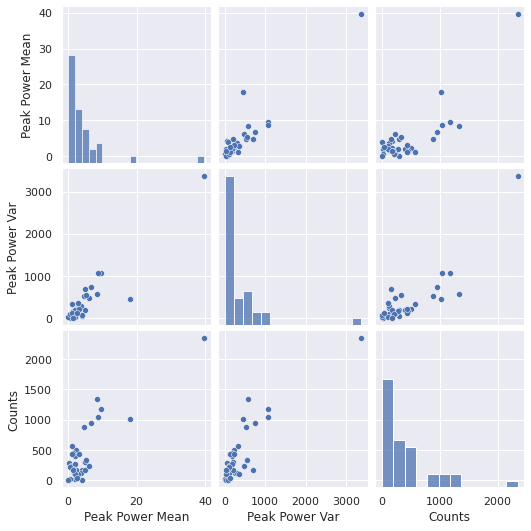

In [3]:
df_diff = df.groupby('Subj').max() - df.groupby('Subj').min()
sns.pairplot(df_diff, vars=['Peak Power Mean', 'Peak Power Var', 'Counts'])


In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_diff.pop('Peak Time Mean')
df_diff.pop('Peak Time Var')
scaled_data = scaler.fit_transform(df_diff.values)

pca = PCA(n_components=10)
pca_data = pca.fit_transform(scaled_data)



KeyError: 'Peak Time Mean'

Text(0.5, 1.0, 'Alpha Event Feature PCA')

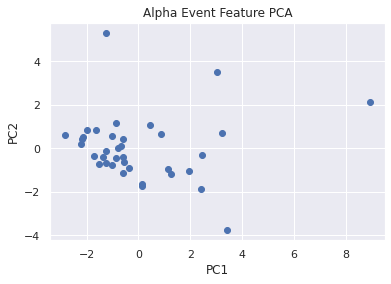

In [61]:
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Alpha Event Diff Feature PCA')

In [55]:
df_diff.columns

Index(['Peak Frequency Mean', 'Lower Frequency Bound Mean',
       'Upper Frequency Bound Mean', 'Frequency Span Mean', 'Peak Time Mean',
       'Peak Power Mean', 'Normalized Peak Power Mean', 'Peak Frequency Var',
       'Lower Frequency Bound Var', 'Upper Frequency Bound Var',
       'Frequency Span Var', 'Peak Time Var', 'Peak Power Var',
       'Normalized Peak Power Var', 'Counts'],
      dtype='object')

In [62]:
subj_ids

NameError: name 'subj_ids' is not defined